#### The Besag-York-Mollie Model for Spatial Data -SVI and Opioid data

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

In [2]:
# these libraries are not dependencies of pymc

import networkx as nx
import nutpie

In [3]:
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Demonstrating the BYM model on Opioid Mortality data

In [4]:
import pandas as pd
import geopandas as gpd

In [5]:
df = gpd.read_file("/home/h6x/git_projects/universal-experiment-lab/experiment_2_bym_modeling/bym_svi_opioid_data/county_svi_county_mortality/svi_mortality_2018.shp")

In [6]:
df.head()

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry
0,15.4,4.2,29372.0,11.3,7.1,14.6,24.2,19.3,7.5,0.8,...,18.4,1.4,5.6,1.0,10.9,01,01001,AL,55200,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,14.4,4.1,22656.0,19.8,11.0,17.8,23.4,14.2,7.0,1.7,...,25.2,1.6,4.2,0.9,19.9,01,01009,AL,57645,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."
2,23.5,6.7,20430.0,15.4,10.2,19.0,22.8,17.7,10.5,0.5,...,26.2,1.8,7.8,1.6,8.8,01,01013,AL,20025,"POLYGON ((-86.90894 31.96167, -86.87498 31.961..."
3,18.6,8.8,24706.0,15.9,9.4,16.8,21.9,20.8,10.4,1.0,...,14.7,1.7,5.8,2.7,15.8,01,01015,AL,115098,"POLYGON ((-86.14622 33.70218, -86.14577 33.704..."
4,16.6,5.0,22827.0,18.6,10.8,18.9,20.7,16.7,9.7,0.1,...,14.0,3.0,7.3,1.5,11.9,01,01017,AL,33826,"POLYGON ((-85.59343 32.89727, -85.59333 32.984..."


#### First study a single state

In [7]:
# get unique state names
states = df['ST_ABBR'].unique()
states

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID',
       'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
       'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND',
       'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
       'VA', 'WA', 'WV', 'WI', 'WY', 'HI', 'DC'], dtype=object)

In [8]:
# drop rows with state name 'AL' or 'AK'
df = df[~df['ST_ABBR'].isin(['AK','HI'])]


In [9]:
# state = 'TX'

In [10]:
# filter by state
# df_state = df[df['ST_ABBR'] == state]

In [11]:
df_state = df

In [12]:
df_state.shape

(3107, 22)

In [13]:
# get number of unique counties 
n_counties = df_state['FIPS'].nunique()
print(n_counties)

3107


<Axes: >

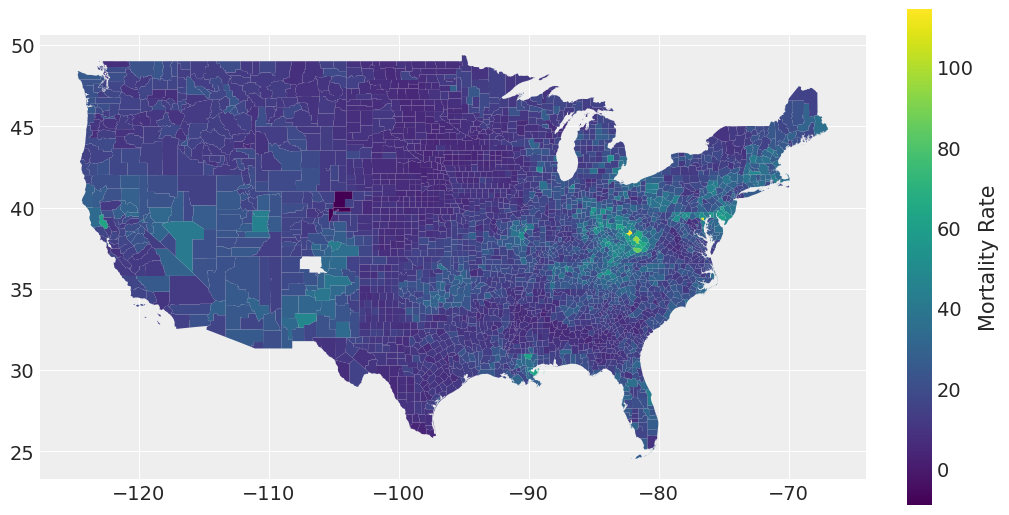

In [14]:
# Assuming df_state is a GeoDataFrame with 'NOD' column and valid geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with customizations
df_state.plot(
    column='NOD', 
    ax=ax, 
    legend=True, 
    # cmap='OrRd',  # Color map
    legend_kwds={'shrink': 0.5, 'label': "Mortality Rate"}  # Adjust legend size
)

<Axes: >

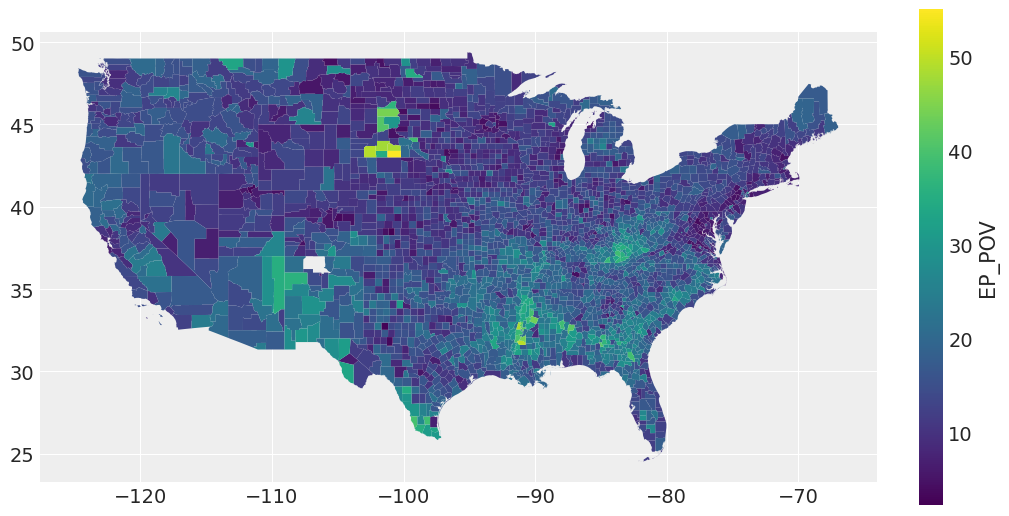

In [15]:
# Assuming df_state is a GeoDataFrame with 'NOD' column and valid geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with customizations
df_state.plot(
    column='EP_POV', 
    ax=ax, 
    legend=True, 
    # cmap='OrRd',  # Color map
    legend_kwds={'shrink': 0.5, 'label': "EP_POV"}  # Adjust legend size
)

In [16]:
def generate_adjacent_counties(dataframe, variable_name):
    """Generate adjacent counties based on given dataframe and variable."""
    filtered_df = dataframe
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()
    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)
    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()
    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county', right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')
    return adjacencies_list, merged_df, county_list

#### making the df suitble to identify adjacencies

Creating the sorted ID

In [17]:
df_state['sortedID'] = range(len(df_state))

In [18]:
df_state = gpd.GeoDataFrame(df_state, geometry='geometry')
df_state.crs = "EPSG:3395"

In [19]:
df_state.head(3)

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry,sortedID
0,15.4,4.2,29372.0,11.3,7.1,14.6,24.2,19.3,7.5,0.8,...,1.4,5.6,1.0,10.9,01,01001,AL,55200,"POLYGON ((-86.921 32.658, -86.920 32.659, -86....",0
1,14.4,4.1,22656.0,19.8,11.0,17.8,23.4,14.2,7.0,1.7,...,1.6,4.2,0.9,19.9,01,01009,AL,57645,"POLYGON ((-86.963 33.858, -86.960 33.858, -86....",1
2,23.5,6.7,20430.0,15.4,10.2,19.0,22.8,17.7,10.5,0.5,...,1.8,7.8,1.6,8.8,01,01013,AL,20025,"POLYGON ((-86.909 31.962, -86.875 31.962, -86....",2


In [20]:
adjacencies_list, merged_df, county_list = generate_adjacent_counties(df_state, 'test')

In [21]:
adjacencies_list

[[2123, 3078, 2932, 10, 1315],
 [24, 1321, 2125, 8, 11, 19],
 [7, 2680, 2682, 1317, 2998, 3078],
 [26, 24, 2449, 11, 1314],
 [1323, 1326, 22, 96, 1447],
 [1320, 7, 9, 1317, 1325],
 [2450, 16, 2571, 15],
 [1418, 1320, 1410, 2122, 2680, 5, 1317, 2],
 [2125, 1, 2451, 21, 16, 19],
 [1320, 13, 5, 12, 1325, 3043],
 [2123, 2933, 0, 1326, 2121, 1315],
 [24, 1, 3, 1314, 19, 1318],
 [2837, 2945, 13, 9, 3043],
 [2192, 2837, 2481, 1320, 9, 12],
 [19, 1318, 18, 1423, 1064, 1048],
 [16, 2571, 6, 17, 1053, 1050, 1058, 2365],
 [8, 2451, 2450, 21, 6, 17, 15],
 [21, 16, 18, 1060, 15, 1050],
 [21, 19, 14, 1048, 1060, 17],
 [1, 8, 21, 11, 1318, 14, 18],
 [569, 1313, 2126, 2266, 2747],
 [8, 16, 19, 18, 17],
 [1326, 4, 1430, 1316, 1447, 85, 2449],
 [3043, 2997, 2933, 1323, 3053, 2177, 2839],
 [26, 25, 1321, 1, 3, 11],
 [2121, 26, 24, 1315, 2120, 1321],
 [2121, 1316, 24, 25, 2449, 3],
 [1329, 2817, 2453, 2452],
 [2134, 2461, 2459, 1334, 1713],
 [1331, 1340, 1352, 2130, 1337],
 [44, 2611, 39, 33, 2877, 1353],

In [22]:
len(adjacencies_list)  

3104

In [23]:
len(merged_df)

3104

In [24]:
merged_df.columns

Index(['county', 'adjacent', 'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP',
       'EP_UNINSUR', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'NOD', 'ST', 'FIPS', 'ST_ABBR', 'E_TOTPOP',
       'geometry', 'sortedID'],
      dtype='object')

In [38]:
merged_df[['county', 'adjacent', 'NOD', 'EP_POV']].head()

,county,adjacent,NOD,EP_POV
0,0,"[2123, 3078, 2932, 10, 1315]",10.9,15.4
1,1,"[24, 1321, 2125, 8, 11, 19]",19.9,14.4
2,2,"[7, 2680, 2682, 1317, 2998, 3078]",8.8,23.5
3,3,"[26, 24, 2449, 11, 1314]",15.8,18.6
4,4,"[1323, 1326, 22, 96, 1447]",11.9,16.6


In [28]:
adjacency_matrix.shape

(3104, 3104)

To actually get our model running, however, we’ll need to convert the edgelist to an adjacency matrix. The code below performs that task along with some other clean up tasks.

In [33]:
# create adjacency matrix
# n = len(merged_df)
n = n_counties
adjacency_matrix = np.zeros((n, n))

In [34]:
# Fill the adjacency matrix
for county, adjacents in zip(merged_df["county"], merged_df["adjacent"]):
    for adjacent in adjacents:
        adjacency_matrix[county, adjacent] = 1


In [35]:
adjacency_matrix.shape

(3107, 3107)

In [39]:
adjacency_matrix[0][10]

1.0

In [40]:
adjacency_matrix[10][0]

1.0

In [41]:
W_state = adjacency_matrix

We’ll compute the scaling factor.

In [42]:
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)

In [43]:
scaling_factor = scaling_factor_sp(W_state)
scaling_factor

2.1688008574796345

we’ll also explore one predictor variable, the social fragmentation index. 

In [44]:
df_state.head()

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry,sortedID
0,15.4,4.2,29372.0,11.3,7.1,14.6,24.2,19.3,7.5,0.8,...,1.4,5.6,1.0,10.9,01,01001,AL,55200,"POLYGON ((-86.921 32.658, -86.920 32.659, -86....",0
1,14.4,4.1,22656.0,19.8,11.0,17.8,23.4,14.2,7.0,1.7,...,1.6,4.2,0.9,19.9,01,01009,AL,57645,"POLYGON ((-86.963 33.858, -86.960 33.858, -86....",1
2,23.5,6.7,20430.0,15.4,10.2,19.0,22.8,17.7,10.5,0.5,...,1.8,7.8,1.6,8.8,01,01013,AL,20025,"POLYGON ((-86.909 31.962, -86.875 31.962, -86....",2
3,18.6,8.8,24706.0,15.9,9.4,16.8,21.9,20.8,10.4,1.0,...,1.7,5.8,2.7,15.8,01,01015,AL,115098,"POLYGON ((-86.146 33.702, -86.146 33.704, -86....",3
4,16.6,5.0,22827.0,18.6,10.8,18.9,20.7,16.7,9.7,0.1,...,3.0,7.3,1.5,11.9,01,01017,AL,33826,"POLYGON ((-85.593 32.897, -85.593 32.984, -85....",4


In [45]:
df_state.columns

Index(['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'NOD',
       'ST', 'FIPS', 'ST_ABBR', 'E_TOTPOP', 'geometry', 'sortedID'],
      dtype='object')

In [46]:
df_state['NOD'].describe()

count    3107.000000
mean       17.556775
std        10.486756
min        -9.000000
25%        10.300000
50%        15.000000
75%        22.000000
max       114.400000
Name: NOD, dtype: float64

In [47]:
df_state['EP_POV'].describe()

count    3107.000000
mean       15.630222
std         6.460610
min         2.300000
25%        11.000000
50%        14.800000
75%        19.100000
max        55.100000
Name: EP_POV, dtype: float64

In [48]:
y = df_state.NOD.values
E = df_state.E_TOTPOP.values
fragment_index = df_state.EP_POV.values

In [59]:
y.shape

(3107,)

In [50]:
# Most census tracts have huge populations
# but a handful have 0. We round
# those up to 10 to avoid triggering an error
# with the log of 0.

E[E < 10] = 10
log_E = np.log(E)

In [51]:
area_idx = df_state["FIPS"].values

In [52]:
coords = {"area_idx": area_idx}

In [53]:
area_idx

array(['01001', '01009', '01013', ..., '48507', '48127', '48247'],
      dtype=object)

In [54]:
coords

{'area_idx': array(['01001', '01009', '01013', ..., '48507', '48127', '48247'],
       dtype=object)}

We can get a sense of the spatial structure by visualizing the adjacency matrix. The figure below only captures the relative position of the census tracks. It doesn’t bother with the absolute position so it doesn’t look like New York City. This representation highlights how the city is composed of several regions of uniformly connected areas, a few central hubs that have a huge number of connections, and then a few narrow corridors.

In [60]:
# build the positions of the nodes. We'll only
# generate the positions once so that we can
# compare visualizations from the data to
# the model predictions.
# I found that running spectral layout first
# and passing it to spring layout makes easy to read
# visualizations for large datasets.

G_nyc = nx.Graph(W_state)
pos = nx.spectral_layout(G_nyc)
pos = nx.spring_layout(G_nyc, pos=pos, seed=RANDOM_SEED)

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


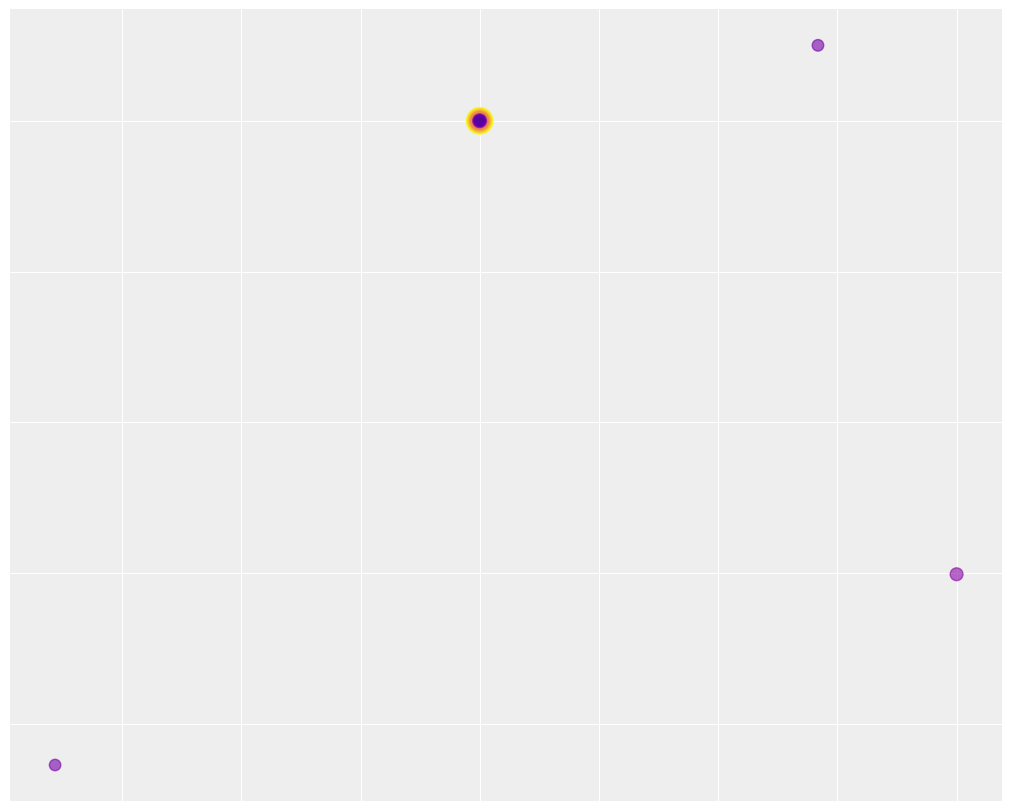

In [61]:
# the spread of the data is pretty high. Most areas have 0 accidents.
# one area has 300. Color-gradient based visualization doesn't work
# well under those conditions. So for the purpose of the color
# we'll cap the accidents at 30 using vmax
#
# however, we'll also make the node size sensitive to the real
# number of accidents. So big yellow nodes have way more accidents
# than small yellow nodes.

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y,
    cmap="plasma",
    vmax=100,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y,
)

We can also visualize the spatial layout of social fragmentation.

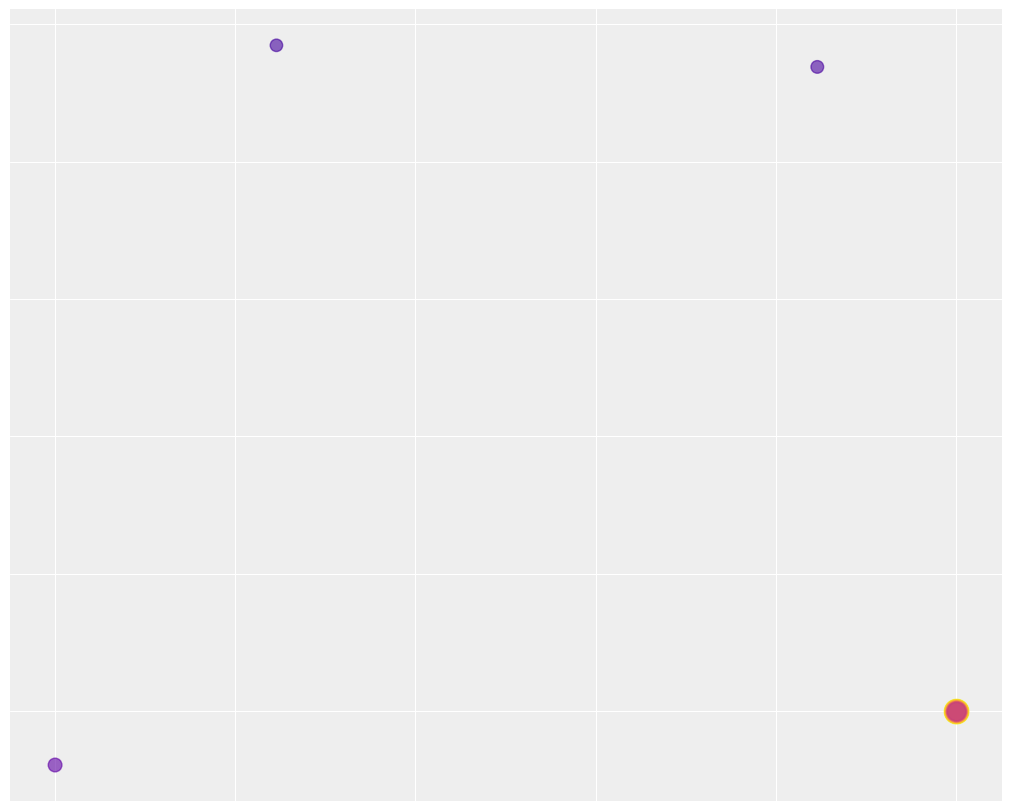

In [57]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=fragment_index,
    cmap="plasma",
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=40 + 5 * fragment_index,
)

Specifying a BYM model with PyMC

In [49]:
with pm.Model(coords=coords) as BYM_model:
    # intercept
    beta0 = pm.Normal("beta0", 0, 1)

    # fragmentation effect
    beta1 = pm.Normal("beta1", 0, 1)

    # independent random effect
    theta = pm.Normal("theta", 0, 1, dims="area_idx")

    # spatially structured random effect
    phi = pm.ICAR("phi", W=W_state, dims="area_idx")

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)

    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pm.Deterministic(
        "mixture", pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi, dims="area_idx"
    )

    # exponential link function to ensure
    # predictions are positive
    mu = pm.Deterministic(
        "mu", pt.exp(log_E + beta0 + beta1 * fragment_index + sigma * mixture), dims="area_idx"
    )

    y_i = pm.Poisson("y_i", mu, observed=y)

Sampling the model

In [ ]:
# if you haven't installed nutpie, it's okay to to just delete
# 'nuts_sampler="nutpie"'. The default sampler took roughly 12 minutes on
# my machine.

with BYM_model:
    idata = pm.sample(500, nuts_sampler="nutpie", random_seed=rng)

We can evaluate the sampler in several ways. First, it looks like all our chains converged. All parameters have rhat values very close to one.



In [ ]:
rhat = az.summary(idata, kind="diagnostics").r_hat.values
sum(rhat > 1.03)

Second, the trace plots on all the main parameters look stationary and well-mixed. They also reveal that the mean of rho is somewhere around 0.50, indicating that spatial effects are likely present in the data.


In [ ]:
az.plot_trace(idata, var_names=["beta0", "beta1", "sigma", "rho"])
plt.tight_layout();

Posterior predictive checking

In the first case, we’ll visualize only the predictions that come from the spatial component of the model. In other words, we are assuming e =0 and we ignore theta and social fragmentation. Then we’ll overlay our predictions onto the same adjacency map we built earlier.



In [ ]:
# draw posterio

with pm.do(BYM_model, {"rho": 1.0, "beta1": 0}):
    y_predict = pm.sample_posterior_predictive(
        idata, var_names=["mu", "mixture"], predictions=True, extend_inferencedata=False
    )

y_spatial_pred = y_predict.predictions.mu.mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y_spatial_pred,
    cmap="plasma",
    vmax=20,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_spatial_pred,
)

The resulting picture is called spatial smoothing. Nearby areas tend to be very similar to each other, resulting in distinct neighborhoods of risk. In the dark purple regions, there is little variance and the number of predicted accidents is low, close to zero.

Finally, we might look at the unstructured variance by assuming e=0. If our model managed to partition variance successfully, there should not be too many spatial clusters left over in the unstructured variance. Instead, variance should be scattered all over the map.

In [ ]:
with pm.do(BYM_model, {"rho": 0.0, "beta1": 0}):
    y_predict = pm.sample_posterior_predictive(
        idata, var_names=["mu", "mixture"], predictions=True, extend_inferencedata=False
    )

y_unspatial_pred = y_predict.predictions.mu.mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y_unspatial_pred,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_unspatial_pred,
)